In [1]:
## IMPORTS

In [4]:
##signed laplacian spectral clustering
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
## ALGORITHM CODE

In [6]:
def calc_degree_matrix(A):
    '''
    Calculates the normalized degree matrix D for matrix A.
    Handles zero-degree rows to avoid division by zero.
    '''
    degrees = np.sum(np.abs(A), axis=1)
    with np.errstate(divide='ignore'):
        D_vals = 1.0 / np.sqrt(degrees)
    D_vals[~np.isfinite(D_vals)] = 0.0  # Replace inf or nan with 0
    D = np.diag(D_vals)
    return D

def calc_laplacian(A,D):
    '''
    calculates normalized laplacian matrix of A
    '''
    n = A.shape[0]
    
    L = np.identity(n) - (D @ A @ D)
    
    return L

def solve_eigen_problem(L):
    '''
    solves the eigen-value problem for laplacian matrix L
    '''
    
    eigvals, eigvecs = np.linalg.eigh(L)
    
    return eigvals, eigvecs


def cluster_embeddings(U, k):
    """
    Run k‐means on the rows of U to get k clusters.
    """
    km = KMeans(n_clusters=k, random_state=42)
    return km.fit_predict(U)

def find_optimal_k(U, k_min=2, k_max=10):
    """
    Compute silhouette scores for each k in [k_min, k_max]
    and return the best k (and its score).
    """
    best_k, best_score = k_min, -1.0
    for k in range(k_min, min(k_max, U.shape[0]-1) + 1):
        labels = cluster_embeddings(U[:, :k], k)
        score = silhouette_score(U[:, :k], labels)
        if score > best_score:
            best_score, best_k = score, k
    return best_k, best_score


def cluster_to_dict(E,k):
    '''
    E : list of embeddings
    k : number of clusters
    '''
    
    clusD = dict(zip(range(k),[[] for i in range(k)]))
    
    for i,e in enumerate(E):
        clusD[e].append(i)
    
    
    return clusD

def draw(G, seed=42,node_colors=None,ax=None):
    # Set edge colors and styles
    edge_colors = []
    edge_styles = []
    for u, v in G.edges():
        if G[u][v]['type'] == 'activation':
            edge_colors.append('green')
            edge_styles.append(('solid', '->'))
        else:
            edge_colors.append('red')
            edge_styles.append(('dashed', '-['))  # corrected from '-]' to '-['

    # Graph layout
    pos = nx.spring_layout(G, seed=seed)

    # Draw nodes and labels
    if node_colors == None:
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=400, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold',ax = ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)     

    # Draw edges by style
    for style in set(edge_styles):
        styled_edges = [(u, v) for (u, v), s in zip(G.edges(), edge_styles) if s == style]
        color = 'green' if style[0] == 'solid' else 'red'
        arrowstyle = style[1]  # either '->' or '-['
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            edgelist=styled_edges,
            edge_color=color,
            style=style[0],
            arrowstyle=arrowstyle,
            arrowsize=12,
            connectionstyle="arc3,rad=0.1",
            width=2
        )

    
    plt.axis('off')

def make_graph(adj_matrix, genes):
    '''
    A : adjacency matrix {1,0,-1}
    nodes : list of node names
    '''

    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(genes)

    # Add edges based on the adjacency matrix
    for i in range(len(genes)):
        for j in range(len(genes)):
            interaction = adj_matrix[i][j]
            if interaction != 0:
                G.add_edge(genes[i], genes[j],
                           type='activation' if interaction ==1  else 'repression',
                           style='->' if interaction == 1 else '-]')
                
                
    return G

def compute_affinity(A, alpha=1.0, Nmax=10):
    """
    Compute a truncated matrix‐exponential affinity:
      K ≈ sum_{n=0}^Nmax (α^n / n!) A^n
    and then take absolute value to ensure nonnegativity.
    """
    N = A.shape[0]
    K = np.eye(N)
    A_power = np.eye(N)
    for n in range(1, Nmax + 1):
        A_power = A_power @ A
        K += (alpha**n / np.math.factorial(n)) * A_power
    return np.abs(K),K

def calc_m(A,n=4,weights = [1,0.5,0.25,0.125]):
    
    An = []
    An.append(A)
    
    for i in range(1,n+1):
        a = An[i-1] @ A
        An.append(a)
    
    M = sum([w*a for w,a in zip(weights,An)])
    
    return np.abs(M),M


def full_pipeline_signed_laplacian(A,n=4, weights = [1,0.5,0.25,0.125], affinity_mode = True, k_min=2,k_max=10,labels = None,plot=False,sd=24):
    
    if affinity_mode:
        #A_a = compute_affinity(A,alpha=alpha,Nmax=Nmax)[1]
        A_a = calc_m(A,n=n,weights = weights)[1]
        #print(A_a)
        A_a2 = calc_m(np.sign(A_a),n=n,weights = weights)[1]
#         A_a3 = calc_m(np.sign(A_a2),n=n,weights = weights)[1]
#         A_a4 = calc_m(np.sign(A_a3),n=n,weights = weights)[1]
#         A_a5 = calc_m(np.sign(A_a4),n=n,weights = weights)[1]
#         A_a6 = calc_m(np.sign(A_a5),n=n,weights = weights)[1]
    else:
        A_a = A
    
    #A_a2 = A_a
    
    D = calc_degree_matrix(np.sign(A_a2))
    
    L = calc_laplacian(A_a2,D)
    
    eigvalues, eigvectors = solve_eigen_problem(L)
    
    best_k, best_score = find_optimal_k(eigvectors, k_min, k_max)
    
    embeddings = cluster_embeddings(eigvectors[:,:best_k],best_k)
    
    
    clusD = cluster_to_dict(list(embeddings),best_k)
    

    
    if plot:
        
        G = make_graph(A,labels)
        
        colors = ['yellow','magenta','cyan','orange','red','skyblue','green']
        
        node_colors = [colors[i] for i in embeddings]
        
        #print(embeddings,node_colors)
        
        fig,axs = plt.subplots(1,2,figsize=(14,7))
        axs = axs.flatten()
        
        axs[0].set_title('Input GRN')
        draw(G,seed=sd,node_colors=None,ax=axs[0])
        axs[1].set_title('Clustered GRN')
        draw(G,seed=sd,node_colors=node_colors,ax=axs[1])
        
    print('Spectral Clustering Completed')
    print(f'Best K : {best_k}\t Silhouette Score : {best_score : .2f}')
    print(f'Cluster Details : ')
    
    for key,value in clusD.items():
        print(f'Cluster {key+1} : {[labels[i] for i in value]}')
        
    
    return A_a,A_a2,D,L,[eigvalues,eigvectors],embeddings

In [7]:
genes4 = ["A", "B", "C", "D","E","F","G","H"]
A4 = np.array([[0,0,1,0,0,0,-1,0],
             [0,0,0,-1,0,0,0,0],
             [1,1,0,0,0,0,0,0],
             [0,0,0,0,1,0,0,0],
             [0,0,0,1,0,-1,0,0],
             [0,0,0,0,0,0,1,0],
             [0,0,0,0,0,1,0,0],
             [0,-1,0,0,0,0,1,0]])

A5 = np.array([[0,0,1,0,0,0,0,1],
             [0,0,0,-1,0,0,0,0],
             [1,1,0,0,0,0,0,0],
             [0,0,0,0,1,0,0,0],
             [0,0,0,1,0,0,0,0],
             [0,0,0,0,0,0,1,0],
             [0,0,0,0,0,1,0,0],
             [0,-1,0,0,0,0,1,0]])

A6 = np.array([[0,0,1,0,0,0,-1,1],
             [0,0,0,-1,0,0,0,0],
             [1,1,0,0,0,0,0,0],
             [0,0,0,0,1,0,0,0],
             [0,0,0,1,0,-1,0,0],
             [0,0,0,0,0,0,1,0],
             [0,0,0,0,0,1,0,1],
             [0,-1,0,0,0,0,1,0]])


genes_t2 = ["A", "B", "C"]

At = np.array([[0,-1,0],
             [0,0,-1],
             [0,0,0]])

At2 = np.array([[0,-1,0],
             [-1,0,-1],
             [0,-1,0]])

At3 = np.array([[0,-1,0,0],
                [0,0,-1,-1],
                [0,0,0,0],
                [0,0,1,0]])

genes_t3 = ["A", "B", "C","D"]



Spectral Clustering Completed
Best K : 2	 Silhouette Score :  0.32
Cluster Details : 
Cluster 1 : ['B']
Cluster 2 : ['A', 'C', 'D']


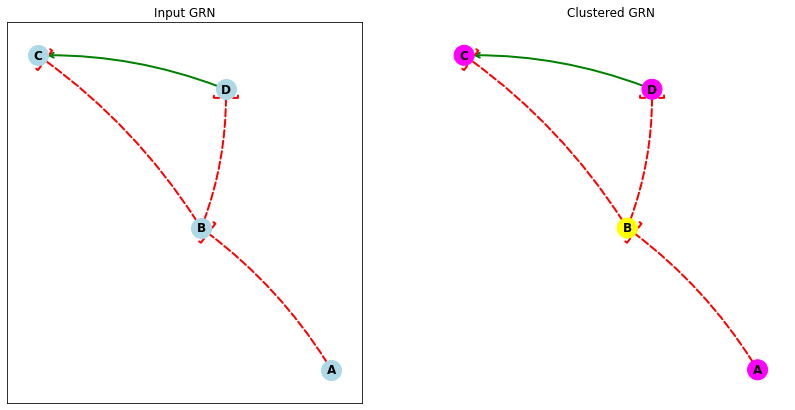

In [8]:

#choose number of steps / order of interaction you want to account for
n = 4
#gemoetrically decaying weight
W = [1/(2**i) for i in range(n)]

A_a,A_a2,D,L,E,embed = full_pipeline_signed_laplacian(At3,n=n,weights=W, affinity_mode = True, labels=genes_t3,plot=True,k_min=2)

In [9]:
A_a

array([[ 0.  , -1.  ,  0.75,  0.5 ],
       [ 0.  ,  0.  , -1.5 , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ]])

In [10]:
A_a2

array([[ 0.  , -1.  ,  2.25,  1.5 ],
       [ 0.  ,  0.  , -1.5 , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ]])

In [11]:
D

array([[0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [12]:
L

array([[ 1.        ,  0.40824829,  0.        , -0.8660254 ],
       [ 0.        ,  1.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
solve_eigen_problem(L)

(array([1., 1., 1., 1.]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]))

<Axes: title={'center': 'Second Affinity Matrix'}>

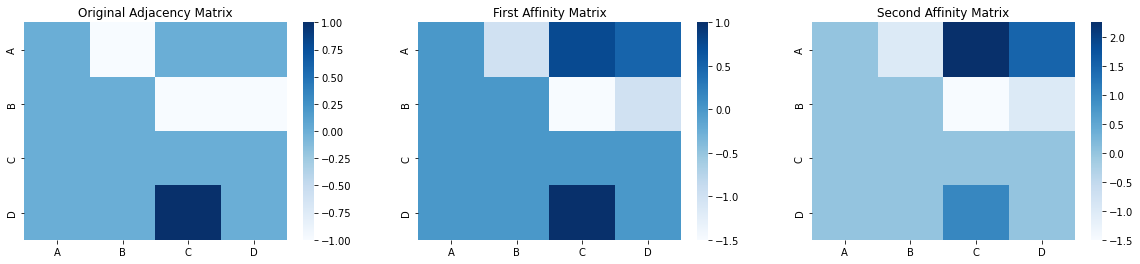

In [26]:
fig, axs = plt.subplots(1,3,figsize=(20,4))

axs = axs.flatten()
axs[0].set_title('Original Adjacency Matrix')
sns.heatmap(pd.DataFrame(At3,columns=genes_t3,index=genes_t3),cmap='Blues',ax=axs[0])
axs[1].set_title('First Affinity Matrix')
sns.heatmap(pd.DataFrame(A_a,columns=genes_t3,index=genes_t3),cmap='Blues',ax=axs[1])
axs[2].set_title('Second Affinity Matrix')
sns.heatmap(pd.DataFrame(A_a2,columns=genes_t3,index=genes_t3),cmap='Blues',ax=axs[2])